## Planky

Problem: Draw a bounding polygon around a point cloud<br>
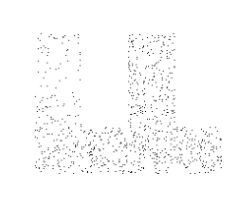

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import PIL

In [2]:
import time
import alphashape
from shapely.geometry.polygon import Polygon

In [3]:
from planky import find_hull
from planky.sweep_kernel import SweepKernel
from planky.util import next_start_angle
from planky.widgets.ipyvideo import Video

In [4]:
v = Video()

In [5]:
def load(fname):
    mask = (cv2.imread(fname)[:,:,0]<255).astype(np.uint8)
    return list(zip(*np.where(mask==1)))

In [7]:
arrow = load("../images/arrow.png")
f = load("../images/F.png")
o = load("../images/o.png")
no_good = load("../images/no_good.png")
big_arrow = load("../images/big_arrow.png")

In [22]:
def find_hull(points, d=10, animate=False, early_stop=None):
    points = np.array(points)
    xmin, ymin = points.min(axis=0)
    xmax, ymax = points.max(axis=0)
    
    N = len(points)
    if early_stop is not None:
        N = min(N, early_stop)
    
    points -= [xmin, ymin]
    points += d+1
    
    grid = np.zeros(
        (
            xmax-xmin+d*2+2,
            ymax-ymin+d*2+2
        )
    )
    
    grid[tuple(points.T)] = 1

    i = points.argmin(axis=0)[1]
    first = tuple(points[i])
    y, x = first
    dy, dx = 0,1

    sk = SweepKernel(d)
    kernel = sk.kernel

    n = 0
    h = 0
    
    steps = {}
    while True:
        if animate:
            time.sleep(0.1)
            _x, _y = grid.shape
            gcp = np.zeros((_x, _y, 3))
            gcp[:,:,0] += grid/2
            gcp[:,:,1] += grid/2
            gcp[:,:,2] += grid/2
            gcp[y-d:y+d+1,x-d:x+d+1,1] += kernel/(2*kernel.max())
    
        n += 1
        new_angle = next_start_angle(dx,dy)
        
        sk.rotate_to(new_angle)
        i, j = sk.apply(grid[y-d:y+d+1, x-d:x+d+1])
        
        dy = d-i
        dx = j-d
        
        if ((y,x) in steps) and (steps[(y,x)]==(y-dy, x+dx)):
            res = []
            gcp = grid.copy()
            _last, _next = (y,x), steps[(y,x)]
            while _next != (y,x):
                if animate:
                    gcp[_last] = 10
                    v.show_frame(gcp)
                res.append(_last)
                _last, _next = _next, steps[_next]
            res.append(_next)
            return res
        steps[(y,x)]=(y-dy, x+dx)
        x+=dx
        y-=dy
        
        if animate:
            gcp[y-1:y+1, x-1:x+1, 0] = 1
            v.show_frame(gcp)

        if n > N: return []


In [23]:
v

Video(children=(Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xa9\x00\x00\x01\x03\x08\x02\x00\…

In [24]:
poly = find_hull(f, 10, animate=True, early_stop=50)
Polygon(poly)

planky done in 0.04787111282348633


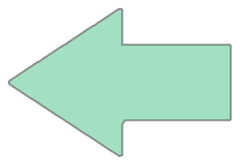

In [28]:
t0 = time.time()
poly = Polygon(find_hull(arrow, 5, animate=False))
print(f"planky done in {time.time()-t0}")
poly

alphashape done in 5.62208890914917


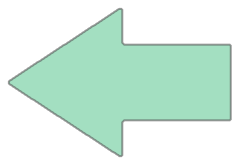

In [30]:
t0 = time.time()
a = alphashape.alphashape(arrow, .5)
print(f"alphashape done in {time.time()-t0}")
a